In [1]:
import numpy as np
import h5py
filename = "GW2_Andy.h5"
hdf = h5py.File(filename, 'r')
print(list(hdf.keys()))
background=hdf['background']
bbh=hdf['binaryblackhole']
ccsn=hdf['ccsn']
glitch=hdf['glitch']

['background', 'binaryblackhole', 'ccsn', 'glitch']


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from typing import Iterable, List
from timeit import default_timer as timer
import scipy

import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

In [12]:
#### Normalize data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

## normalize to first detector
background_norm0 = scaler.fit_transform(background[:,0])
bbh_norm0 = scaler.transform(bbh[:,0])
ccsn_norm0 = scaler.transform(ccsn[:,0])
glitch_norm0 = scaler.transform(glitch[:,0])

# normalize to second detector
background_norm1 = scaler.fit_transform(background[:,1])
bbh_norm1 = scaler.transform(bbh[:,1])
ccsn_norm1 = scaler.transform(ccsn[:,1])
glitch_norm1 = scaler.transform(glitch[:,1])

# put into arrays
bbh_norm = np.array([bbh_norm0, bbh_norm1])
background_norm = np.array([background_norm0, background_norm1])
ccsn_norm = np.array([ccsn_norm0, ccsn_norm1])
glitch_norm = np.array([glitch_norm0, glitch_norm1])


# print shape
bbh_norm.shape


(2, 2048, 4096)

In [31]:
bbh_norm[:,0,:].shape

(2, 4096)

In [69]:
### Spectrogram function

# create a function that takes in an array of shape (2, 4096) and outputs a spectrogram of shape (2, 128 x 128) using scipy.signal.spectrogram

dt = 0.001

def make_spectrogram (array):
    spec_in = scipy.signal.spectrogram(array, fs=1/dt, nperseg=175, noverlap=120, mode = 'magnitude')
    spec = spec_in[2]
    return spec



In [71]:
### Use function to create spectrograms for all data
### the input data has shape (2, 2048, 4096), and the output data should have shape (2, 2048, x, y) 
### where x and y are the spectrogram dimensions

def convert_data_to_spectrogram (data):
    spectrogram = np.zeros((2, 2048, 88, 72))
    for i in range(2048):
        spectrogram[:,i,:,:] = make_spectrogram(data[:,i,:])
    return spectrogram



In [74]:
### Create spectrograms for all data

bbh_spectrogram = convert_data_to_spectrogram(bbh_norm)
background_spectrogram = convert_data_to_spectrogram(background_norm)
ccsn_spectrogram = convert_data_to_spectrogram(ccsn_norm)
glitch_spectrogram = convert_data_to_spectrogram(glitch_norm)

### convert above arrays to tensors of the following shape
### (2, 2048, 88, 72) -> (2048, 2, 88, 72) -- (samples, channels, x, y )

bbh_tensor = torch.from_numpy(bbh_spectrogram).permute(1,0,2,3)
background_tensor = torch.from_numpy(background_spectrogram).permute(1,0,2,3)
ccsn_tensor = torch.from_numpy(ccsn_spectrogram).permute(1,0,2,3)
glitch_tensor = torch.from_numpy(glitch_spectrogram).permute(1,0,2,3)


In [75]:
### normalize spectrograms?

In [99]:
### randomly split data into training, validation, and test sets

from sklearn.model_selection import train_test_split

bbh_train, bbh_test = train_test_split(bbh_tensor, test_size=0.2, random_state=42)
bbh_train, bbh_val = train_test_split(bbh_train, test_size=0.2, random_state=42)

background_train, background_test = train_test_split(background_tensor, test_size=0.2, random_state=42)
background_train, background_val = train_test_split(background_train, test_size=0.2, random_state=42)

ccsn_train, ccsn_test = train_test_split(ccsn_tensor, test_size=0.2, random_state=42)
ccsn_train, ccsn_val = train_test_split(ccsn_train, test_size=0.2, random_state=42)

glitch_train, glitch_test = train_test_split(glitch_tensor, test_size=0.2, random_state=42)
glitch_train, glitch_val = train_test_split(glitch_train, test_size=0.2, random_state=42)


### create labels for data
## 0 -> bbh
## 1 -> background
## 2 -> ccsn
## 3 -> glitch

bbh_train_labels = np.zeros(len(bbh_train))
bbh_val_labels = np.zeros(len(bbh_val))
bbh_test_labels = np.zeros(len(bbh_test))

background_train_labels = np.ones(len(background_train))
background_val_labels = np.ones(len(background_val))
background_test_labels = np.ones(len(background_test))

ccsn_train_labels = np.ones(len(ccsn_train))*2
ccsn_val_labels = np.ones(len(ccsn_val))*2
ccsn_test_labels = np.ones(len(ccsn_test))*2

glitch_train_labels = np.ones(len(glitch_train))*3
glitch_val_labels = np.ones(len(glitch_val))*3
glitch_test_labels = np.ones(len(glitch_test))*3


### concatenate data and labels

train_data = torch.cat((bbh_train, background_train, ccsn_train, glitch_train), 0)
train_labels = np.concatenate((bbh_train_labels, background_train_labels, ccsn_train_labels, glitch_train_labels), 0)

val_data = torch.cat((bbh_val, background_val, ccsn_val, glitch_val), 0)
val_labels = np.concatenate((bbh_val_labels, background_val_labels, ccsn_val_labels, glitch_val_labels), 0)

test_data = torch.cat((bbh_test, background_test, ccsn_test, glitch_test), 0)
test_labels = np.concatenate((bbh_test_labels, background_test_labels, ccsn_test_labels, glitch_test_labels), 0)


### shuffle data -- this is important for training

from sklearn.utils import shuffle

train_data, train_labels = shuffle(train_data, train_labels)
val_data, val_labels = shuffle(val_data, val_labels)
test_data, test_labels = shuffle(test_data, test_labels)


### create dataloaders -- this is what we will use to train the model

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_data, torch.from_numpy(train_labels))
val_dataset = TensorDataset(val_data, torch.from_numpy(val_labels))
test_dataset = TensorDataset(test_data, torch.from_numpy(test_labels))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)




In [77]:
### print shapes of training, validation, and test sets

print(bbh_train.shape)
print(bbh_val.shape)
print(bbh_test.shape)

torch.Size([1310, 2, 88, 72])
torch.Size([328, 2, 88, 72])
torch.Size([410, 2, 88, 72])


In [95]:
### create a CNN network to train on the data

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # 2 input image channels (for the two images),
        # 16 output channels/feature maps, 3x3 square convolution kernel
        # (for the first convolutional layer)
        self.conv1 = nn.Conv2d(2, 16, 3, padding=1)

        # 16 input channels (from the first convolutional layer),
        # 32 output channels/feature maps, 3x3 square convolution kernel
        # (for the second convolutional layer)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        # max pooling over a 2x2 window
        self.pool = nn.MaxPool2d(2, 2)

        # linearly map the output of the 2nd convolutional layer to 128
        # features before the final output layer
        self.fc1 = nn.Linear(32 * 22 * 18, 128)

        # linearly map 128 features to 64 features
        self.fc2 = nn.Linear(128, 64)

        # linearly map 64 features to 4 features
        self.fc3 = nn.Linear(64, 4)

        # dropout layer with p=0.5
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # flatten image input
        x = x.view(-1, 32 * 22 * 18)

        # add dropout layer
        x = self.dropout(x)

        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))

        # add dropout layer
        x = self.dropout(x)

        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))

        # add dropout layer
        x = self.dropout(x)

        # add output layer
        x = self.fc3(x)

        return x

In [96]:
#### Define hyperparameters

epochs = 30
learning_rate = 0.001

### define loss function and optimizer

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model

Net(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12672, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [97]:
### tracked values
train_loss_list = []
validation_accuracy_list = np.zeros((epochs,))

In [98]:
### Train the model

for epoch in range(epochs):

    train_loss = 0.0
    validation_accuracy = 0.0

    model.train()

    for data, labels in train_dataloader:

        optimizer.zero_grad()

        output = model(data.float())

        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)

    model.eval()

    for data, labels in val_dataloader:

        output = model(data.float())

        _, preds = torch.max(output, 1)

        validation_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss/len(train_dataloader.dataset)
    validation_accuracy = validation_accuracy.double()/len(val_dataloader.dataset)

    train_loss_list.append(train_loss)
    validation_accuracy_list[epoch] = validation_accuracy

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, validation_accuracy))

KeyboardInterrupt: 

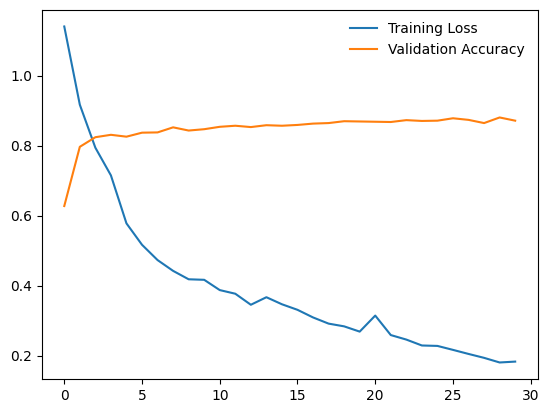

In [88]:
### plot training loss and validation accuracy

plt.plot(train_loss_list, label='Training Loss')
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.legend(frameon=False)
plt.show()

In [89]:
### Test the model

test_accuracy = 0.0

model.eval()

for data, labels in test_dataloader:
    
        output = model(data.float())
    
        _, preds = torch.max(output, 1)
    
        test_accuracy += torch.sum(preds == labels.data)

test_accuracy = test_accuracy.double()/len(test_dataloader.dataset)

print('Test Accuracy: {:.6f}'.format(test_accuracy))


Test Accuracy: 0.884756


Correctly identified sample
True label: 1.0
Predicted label: 1



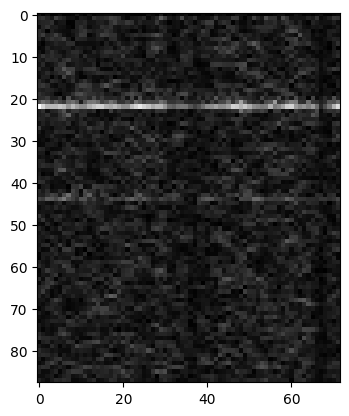

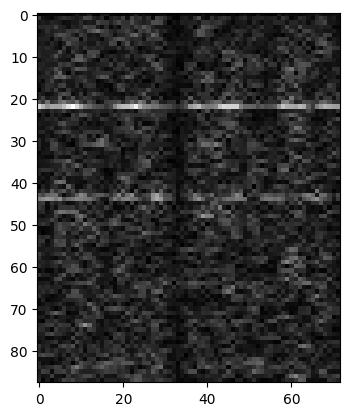

Correctly identified sample
True label: 3.0
Predicted label: 3



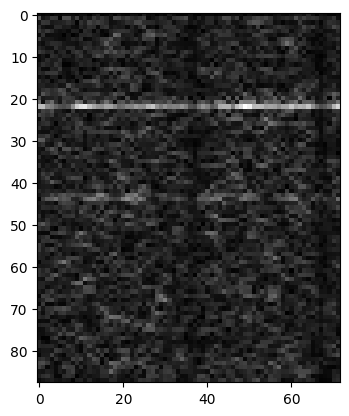

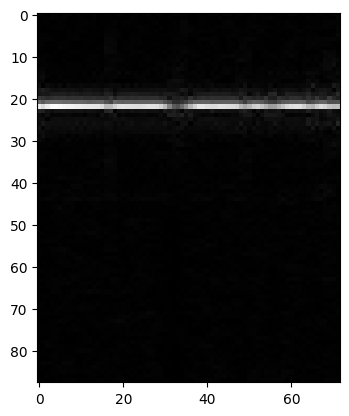

Correctly identified sample
True label: 1.0
Predicted label: 1



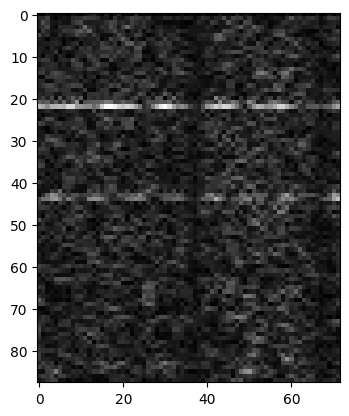

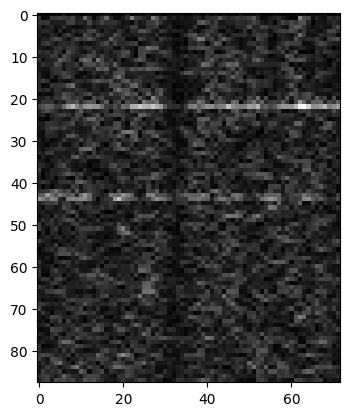

Correctly identified sample
True label: 2.0
Predicted label: 2



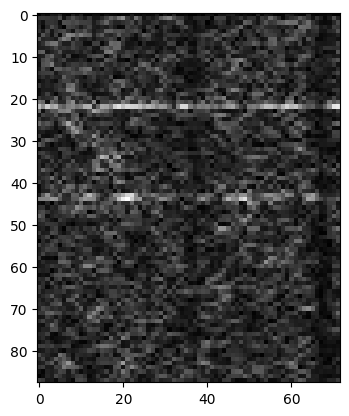

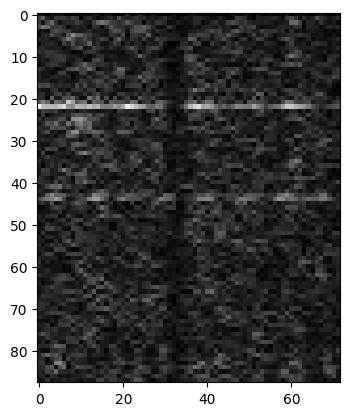

Correctly identified sample
True label: 2.0
Predicted label: 2



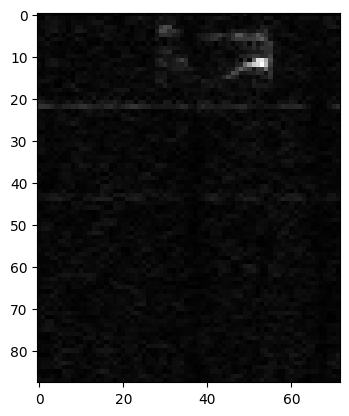

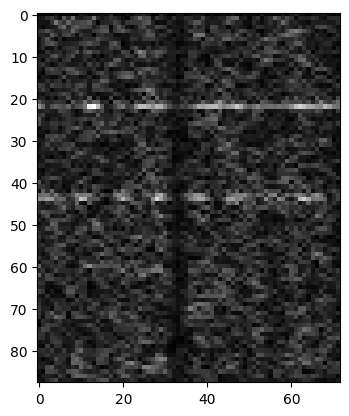

In [94]:
### show some correctly identified samples and some incorrectly identified samples, along with their labels 
## and the model's predicted labels

model.eval()

for data, labels in test_dataloader:

    output = model(data.float())

    _, preds = torch.max(output, 1)

    for i in range(5):

        if preds[i] == labels.data[i]:
            print('Correctly identified sample')
        else:
            print('Incorrectly identified sample')

        print('True label: {}'.format(labels.data[i]))
        print('Predicted label: {}'.format(preds[i]))
        print('')

        plt.imshow(data[i,0,:,:], cmap='gray')
        plt.show()

        plt.imshow(data[i,1,:,:], cmap='gray')
        plt.show()

        if i == 10:
            break

    break



